In [2]:
import pandas as pd
import ast
import json
from typing import Union, Literal
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing


def initialize_data(path: str, year: int):
    # puid_df = pd.read_csv(path)
    # puid_df['keys'] = puid_df['keys'].apply(ast.literal_eval)
    # puid_df['values'] = puid_df['values'].apply(ast.literal_eval)
    # puid_df['meta'] = puid_df['meta'].apply(ast.literal_eval)
    # meta = list(map(json.loads, puid_df['meta'][0]))
    # titles = list(map(
    #     lambda x: f'{"Прямое" if  x["direction"] == 1 else "Обратное"}, полоса {x["lane"]}', meta))
    # keys = puid_df['keys'][0][0]
    # general_key_indices = [keys.index('volume'), keys.index(
    #     'speed'), keys.index('occupancy')]

    df = pd.read_csv(path)
    df = df.set_index('index')
    df.index = pd.to_datetime(df.index)

    year_range = pd.date_range(
        f'{year}-01-01 00:00', f'{year}-12-31 23:55', freq='5Min')
    df = df.reindex(year_range)
    df = df.reset_index()

    return df


def get_na_intervals(df: pd.DataFrame) -> pd.DataFrame:
    df['is_nan'] = df['volume'].isna().astype(int)
    df['group'] = (df['is_nan'].diff() == 1).cumsum()
    nan_intervals = df[df['is_nan'] == 1].groupby(
        'group').agg(start=('index', 'first'), end=('index', 'last'))
    df = df.set_index('index')
    df = df.drop(['is_nan', 'group'], axis=1)
    nan_intervals['duration'] = nan_intervals['end'] - nan_intervals['start']
    return nan_intervals


def fill_na(df: pd.DataFrame, nan_interval: (pd.Timestamp, pd.Timestamp, pd.Timedelta), method:  Literal['exp_smooth', 'moving_average']):
    start, end, duration = nan_interval
    if (method == 'exp_smooth'):
        # check type of interval
        # interval_len = pd.Timedelta()
        print(start, end, duration)


def process_dataframe(path: str):
    df = initialize_data(path, 2024)
    nan_intervals = get_na_intervals(df)
    rows = list(nan_intervals.itertuples())
    nan_intervals.itertuples(lambda interval: fill_na(
        df, interval, method='exp_smooth'))


process_dataframe('test\input-data__19-03__23-28-55.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'test\\input-data__19-03__23-28-55.csv'

In [3]:
df = pd.read_csv('input-data__19-03__23-28-55.csv')
# nan_intervals = get_na_intervals(df, 2024)
# nan_intervals

In [4]:
df = df.set_index('index')
df.index = pd.to_datetime(df.index)

In [5]:
year = 2024
year_range = pd.date_range(
    f'{year}-01-01 00:00', f'{year}-12-31 23:55', freq='5Min')
df = df.reindex(year_range)

In [6]:
df

,volume
2024-01-01 00:00:00,NaN
2024-01-01 00:05:00,NaN
2024-01-01 00:10:00,NaN
2024-01-01 00:15:00,NaN
2024-01-01 00:20:00,NaN
...,...
2024-12-31 23:35:00,NaN
2024-12-31 23:40:00,NaN
2024-12-31 23:45:00,NaN
2024-12-31 23:50:00,NaN


In [7]:
df = df.reset_index()
df['is_nan'] = df['volume'].isna().astype(int)
df['group'] = (df['is_nan'].diff() == 1).cumsum()
nan_intervals = df[df['is_nan'] == 1].groupby(
    'group').agg(start=('index', 'first'), end=('index', 'last'))

In [8]:
df = df.set_index('index')
df

,volume,is_nan,group
index,,,
2024-01-01 00:00:00,NaN,1,0
2024-01-01 00:05:00,NaN,1,0
2024-01-01 00:10:00,NaN,1,0
2024-01-01 00:15:00,NaN,1,0
2024-01-01 00:20:00,NaN,1,0
...,...,...,...
2024-12-31 23:35:00,NaN,1,2
2024-12-31 23:40:00,NaN,1,2
2024-12-31 23:45:00,NaN,1,2


In [9]:
df = df.drop(['is_nan', 'group'], axis=1)
df

,volume
index,
2024-01-01 00:00:00,NaN
2024-01-01 00:05:00,NaN
2024-01-01 00:10:00,NaN
2024-01-01 00:15:00,NaN
2024-01-01 00:20:00,NaN
...,...
2024-12-31 23:35:00,NaN
2024-12-31 23:40:00,NaN
2024-12-31 23:45:00,NaN


In [10]:
nan_intervals['duration'] = nan_intervals['end'] - nan_intervals['start']

In [11]:
nan_intervals

,start,end,duration
group,,,
0,2024-01-01 00:00:00,2024-05-10 05:15:00,130 days 05:15:00
1,2024-05-16 19:15:00,2024-05-17 11:35:00,0 days 16:20:00
2,2024-05-18 23:20:00,2024-12-31 23:55:00,227 days 00:35:00


In [30]:
start, end, duration = nan_intervals.iloc[1]

In [20]:
start - pd.Timedelta(days=7)

Timestamp('2023-12-25 00:00:00')

<Axes: xlabel='index'>

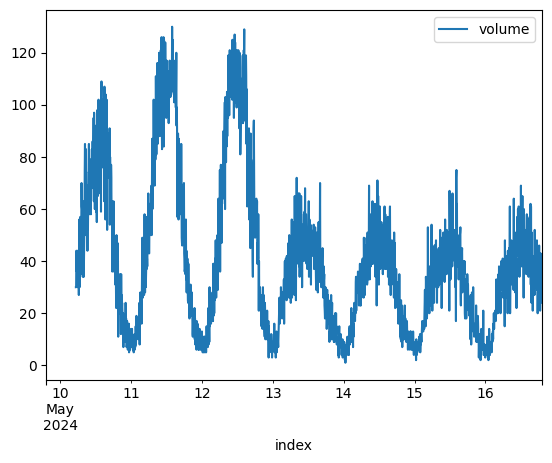

In [32]:
# последний день перед пустым интервалом
df[start - pd.Timedelta(days=7):start][:-1].plot()

In [64]:
train = df[~df['volume'].isna()][start -
                                 pd.Timedelta(days=7):start][:-1]

In [69]:
train

,volume,forecast
index,,
2024-05-10 05:20:00,30.0,NaN
2024-05-10 05:25:00,30.0,NaN
2024-05-10 05:30:00,44.0,NaN
2024-05-10 05:35:00,40.0,NaN
2024-05-10 05:40:00,36.0,NaN
...,...,...
2024-05-16 18:45:00,24.0,NaN
2024-05-16 18:50:00,25.0,NaN
2024-05-16 18:55:00,36.0,NaN


In [71]:
first_timestamp = train.index[-1]
train_start = (first_timestamp -
               pd.Timedelta(days=first_timestamp.weekday())).normalize()
train_start

Timestamp('2024-05-13 00:00:00')

In [72]:
train = train[train_start:]

In [73]:
fit = ExponentialSmoothing(
    train['volume'],
    trend=None,
    seasonal='add',
    seasonal_periods=24 * 60 / 5,
    damped_trend=False,
).fit()

d:\projects\PycharmProjects\transportation\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


In [74]:
nan_counts = (int)((end - start) / pd.Timedelta(minutes=5))
nan_counts

196

In [75]:
forecast = pd.DataFrame(pd.Series(fit.forecast(steps=nan_counts)), columns=['forecast'])

In [76]:
forecast

,forecast
2024-05-16 19:10:00,13.632353
2024-05-16 19:15:00,18.612901
2024-05-16 19:20:00,15.599852
2024-05-16 19:25:00,25.893519
2024-05-16 19:30:00,25.580923
...,...
2024-05-17 11:05:00,51.116202
2024-05-17 11:10:00,44.116103
2024-05-17 11:15:00,55.615096
2024-05-17 11:20:00,49.613545


In [77]:
train['forecast'] = forecast
forecast['volume'] = train['volume']

C:\Users\riabt\AppData\Local\Temp\ipykernel_35332\3107351160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['forecast'] = forecast


<Axes: >

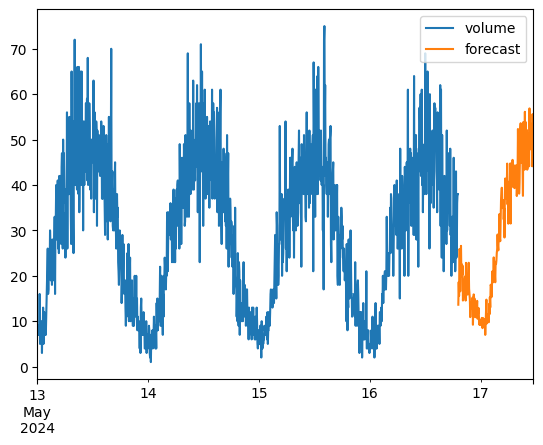

In [78]:
pd.concat([train, forecast]).plot()

In [123]:
def initialize_data(path: str, year: int):
    df = pd.read_csv(path)
    df = df.set_index('index')
    df.index = pd.to_datetime(df.index)
    year_range = pd.date_range(
        f'{year}-01-01 00:00', f'{year}-12-31 23:55', freq='5Min')
    df = df.reindex(year_range)
    # df = df.reset_index()

    return df


def get_na_intervals(df: pd.DataFrame) -> pd.DataFrame:
    df['is_nan'] = df['volume'].isna().astype(int)
    df['group'] = (df['is_nan'].diff() == 1).cumsum()
    df = df.reset_index()
    nan_intervals = df[df['is_nan'] == 1].groupby(
        'group').agg(start=('index', 'first'), end=('index', 'last'))
    df = df.set_index('index')
    df = df.drop(['is_nan', 'group'], axis=1)
    nan_intervals['duration'] = nan_intervals['end'] - nan_intervals['start']
    return nan_intervals

df = initialize_data('input-data__19-03__23-28-55.csv', 2024)
nan_intervals = get_na_intervals(df)

for row in nan_intervals.itertuples():
    print(len(df[~df['volume'].isna()][:row.start]))

# df[:nan_intervals.iloc[0].start]
# df.index

0
1895
2323


In [124]:
pd.DataFrame(index=df.index)

""
2024-01-01 00:00:00
2024-01-01 00:05:00
2024-01-01 00:10:00
2024-01-01 00:15:00
2024-01-01 00:20:00
...
2024-12-31 23:35:00
2024-12-31 23:40:00
2024-12-31 23:45:00
2024-12-31 23:50:00
